In [11]:
import os
import io
from dotenv import load_dotenv
import pandas as pd
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict, Optional, Annotated
from langgraph.graph import StateGraph, START, END
import openai
import time
from google.cloud import speech  # Google STT 사용을 위한 라이브러리
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import SystemMessage
from datasets import Dataset
import ast
from audio import real_time_transcription
from video import start_video_recording, stop_video_recording
from prompt import evaluation_prompt, question_prompt, model_answer
import pdfplumber
import random
import json
from langchain_core.runnables import RunnableConfig

# 추가된 라이브러리
import networkx as nx
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

# BERTScore를 위한 라이브러리
from bert_score import score as bert_score
import numpy as np
import torch
import nltk

nltk.download('punkt')

# RAGAS 평가 지표를 위한 라이브러리
from ragas import evaluate
from ragas.metrics import answer_relevancy, faithfulness, context_recall, context_precision

# 한글 폰트 등록 (고양덕양 폰트)
pdfmetrics.registerFont(TTFont('고양덕양', 'C:/Windows/Fonts/고양덕양 B.ttf'))

# 면접 데이터를 저장할 리스트 초기화
interview_rounds = []

config = RunnableConfig(recursion_limit=2 + 3 * 20 + 3, configurable={"thread_id": "THREAD_ID"})

load_dotenv()

# ChatOpenAI 클라이언트 생성 함수
def get_client():
    return ChatOpenAI(
        model="gpt-4",
        streaming=True,
        openai_api_key=os.getenv("OPENAI_API_KEY")
    )

# ChatOpenAI 인스턴스 생성
chat = get_client()

# State 정의
class State(TypedDict):
    tech_keywords: Annotated[str, "multiple"] = None
    ideal_answer: Optional[str] = None  # 참고자료
    model_answer: Optional[str] = None  # 모범답안
    question: Optional[str] = None
    answer_text: Optional[str] = None
    evaluation: Optional[str] = None
    question_evaluation: Optional[str] = None  # 질문 평가 결과 추가
    reference_docs: Optional[str] = None
    feedback: Optional[str] = None
    is_stop: Optional[bool] = False
    question_count: Optional[int] = 0
    max_questions: Optional[int] = 5
    selected_keyword: Optional[str] = None

# FAISS 데이터베이스 로드
vector_db = FAISS.load_local(
    folder_path="C:/dev/SKN03-Final_Project/faiss_db",
    index_name="python_csv01_chunk600",
    embeddings=OpenAIEmbeddings(),
    allow_dangerous_deserialization=True,
)

# Retriever 설정
retriever = vector_db.as_retriever()

# 예시 기술 용어 리스트
example_tech_terms = ["python", "파이썬", "javascript", "자바스크립트", "java", "자바", "react", "리액트", "css", "씨에스에스",
                      "html", "에이치티엠엘", "node.js", "노드제이에스", "binary file", "argument", "context", "lambda", "parameter"]

# 이력서 파일 경로 설정
pdf_path = 'c:/dev/SKN03-Final_Project/이력서_20240508.pdf'

# 이력서 로드 함수
def resume_loader(pdf_path):
    resume_text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            resume_text += page.extract_text() + "\n"  # 각 페이지의 텍스트를 추가
    return resume_text

# 키워드 추출 노드
def extract_keywords(state: State) -> State:
    resume_text = state["resume_text"]
    tech_keywords = ", ".join(term for term in example_tech_terms if term.lower() in resume_text.lower())
    return {**state, "tech_keywords": tech_keywords}

# 질문 키워드 추출 함수
def extract_keywords_from_resume(resume_text: str) -> str:
    prompt = f"이력서에서 주요 기술 키워드를 추출해 주세요:\n이력서: {resume_text}"
    response = chat.invoke([SystemMessage(content=prompt)])
    return response.content.strip()

# 질문 생성 노드
def generate_question(state: State) -> State:
    tech_keywords = state["tech_keywords"]
    prev_answer = state.get("answer_text", None)
    retrieval_index = state.get("retrieval_index", 0)

    # 기술 키워드 리스트 생성
    keywords_list = tech_keywords.split(", ")

    # 랜덤으로 키워드 선택
    selected_keyword = random.choice(keywords_list)
    state["selected_keyword"] = selected_keyword

    # 선택된 키워드로 문서 검색
    search_results = retriever.get_relevant_documents(selected_keyword)

    # 검색 결과가 있을 경우
    if search_results:
        retrieved_content = search_results[0].page_content
        reference_docs = search_results[0].metadata.get("source", "출처를 알 수 없음")
    else:
        retrieved_content = "관련 문서를 찾을 수 없습니다."
        reference_docs = "출처를 알 수 없음"

    # 이전 답변 여부에 따라 프롬프트 생성
    if prev_answer is None:
        query_prompt = (question_prompt() +
                        f"다음 공식 문서를 참조하여 기술 면접 질문을 생성해 주세요:\n{retrieved_content}\n"
                        f"기술 스택: {selected_keyword}\n"
                        f"하나의 질문만 반환해주시기 바랍니다.")
    else:
        query_prompt = (question_prompt() +
                        f"이전 질문과는 다른 관점에서 질문을 생성해 주세요.\n"
                        f"이전 답변: {prev_answer}\n과 기술 스택: {selected_keyword}\n,다음 공식 문서:\n{retrieved_content}\n를 참조하여 후속 면접질문을 생성해주세요"
                        f"하나의 질문만 반환해주시기 바랍니다.")

    # ChatGPT를 사용하여 질문 생성
    response = chat.invoke([SystemMessage(content=str(query_prompt))])

    # 상태 업데이트
    state.update({
        "question": response.content.strip(),
        "reference_docs": reference_docs,
        "ideal_answer": retrieved_content.strip(),
        "question_count": state["question_count"] + 1,
        "retrieval_index": retrieval_index + 1,
    })

    return state

# 모범답안 생성 노드
def generate_model_answer(state: State) -> State:
    question = state["question"]
    retrieved_content = state["ideal_answer"]
    prompt = model_answer(question, retrieved_content)

    # ChatGPT를 사용하여 모범답안 생성
    response = chat.invoke([SystemMessage(content=prompt)])

    # 상태 업데이트
    state["model_answer"] = response.content.strip()
    return state

# 답변 녹음 및 변환 노드
def record_and_transcribe(state: State) -> State:
    
    answer_text = real_time_transcription()
    state["answer_text"] = answer_text
    return state

# 피드백 생성 함수
def generate_feedback(state: State) -> State:
    answer = state["answer_text"]
    ideal_answer = state["ideal_answer"]
    prompt = evaluation_prompt(answer, ideal_answer)

    # ChatGPT를 사용하여 피드백 생성
    response = chat.invoke([SystemMessage(content=prompt)])

    # 상태 업데이트
    state["feedback"] = response.content.strip()
    return state

# 답변 평가 함수
def evaluate_answer(state: State) -> State:
    answer_text = state["answer_text"]
    model_answer = state["model_answer"]
    ideal_answer = state["ideal_answer"]
    feedback = state["feedback"]
    selected_keyword = state["selected_keyword"]

    if not answer_text or not model_answer:
        print("Error: Missing answer_text or model_answer for evaluation.")
        return state

    # BERTScore 계산
    P, R, F1 = bert_score(
        [answer_text], [model_answer], lang="ko", rescale_with_baseline=True
    )
    bert_score_f1 = F1.item()

    # RAGAS 평가를 위한 데이터셋 생성
    df = pd.DataFrame([{
        "question": state["question"],
        "answer": answer_text,
        "reference": model_answer,
        "ground_truth": model_answer,
        "contexts": json.dumps([ideal_answer])
    }])

    # 데이터셋 변환
    test_dataset = Dataset.from_pandas(df)
    test_dataset = test_dataset.map(lambda example: {"contexts": ast.literal_eval(example["contexts"])})

    # RAGAS 평가 적용 (답변 평가)
    ragas_result = evaluate(
        dataset=test_dataset,
        metrics=[answer_relevancy, faithfulness, context_precision, context_recall],
    )

    # RAGAS 결과를 데이터프레임으로 변환
    ragas_df = ragas_result.to_pandas()

    # 평가 결과 저장
    evaluation_result = {
        "BERTScore": bert_score_f1,
        "Answer_Relevancy": ragas_df.iloc[0]['answer_relevancy'],
        "Faithfulness": ragas_df.iloc[0]['faithfulness'],
        "Context_Precision": ragas_df.iloc[0]['context_precision'],
        "Context_Recall": ragas_df.iloc[0]['context_recall'],
    }

    state["evaluation"] = evaluation_result

    # 인터뷰 라운드 데이터 저장
    interview_rounds.append({
        "question": state["question"],
        "answer": state["answer_text"],
        "model_answer": state["model_answer"],
        "feedback": state["feedback"],
        "evaluation": state["evaluation"],
        "question_evaluation": state.get("question_evaluation", {}),  # 질문 평가 결과 포함
        "selected_keyword": selected_keyword,
    })

    # CSV 파일에 평가 결과 저장
    final_df = pd.DataFrame([{
        "Question": state["question"],
        "Answer": state["answer_text"],
        "Model_Answer": state["model_answer"],
        "Feedback": state["feedback"],
        "BERTScore": bert_score_f1,
        "Answer_Relevancy": ragas_df.iloc[0]['answer_relevancy'],
        "Faithfulness": ragas_df.iloc[0]['faithfulness'],
        "Context_Precision": ragas_df.iloc[0]['context_precision'],
        "Context_Recall": ragas_df.iloc[0]['context_recall'],
    }])

    # CSV 파일에 저장 (추가 모드로 저장하며, 파일이 없으면 헤더를 포함)
    final_df.to_csv("mock_interview_results.csv", mode='a', index=False, header=not os.path.exists("mock_interview_results.csv"))

    print("Results saved to 'mock_interview_results.csv'")  # 저장 확인 메시지

    return state

# 질문 평가 함수
def evaluate_question(state: State) -> State:
    generated_question = state["question"]
    reference_context = state["ideal_answer"]  # 질문 생성 시 참조한 컨텍스트

    if not generated_question or not reference_context:
        print("Error: Missing generated_question or reference_context for evaluation.")
        return state

    # RAGAS 평가를 위한 데이터셋 생성 (질문 평가)
    df = pd.DataFrame([{
        "question": reference_context,  # 컨텍스트를 질문으로 사용
        "answer": generated_question,   # 생성된 질문을 답변으로 간주
        "reference": reference_context,
        "ground_truth": reference_context,
        "contexts": json.dumps([reference_context])
    }])

    # 데이터셋 변환
    test_dataset = Dataset.from_pandas(df)
    test_dataset = test_dataset.map(lambda example: {"contexts": ast.literal_eval(example["contexts"])})

    # RAGAS 평가 적용 (질문 평가)
    ragas_result = evaluate(
        dataset=test_dataset,
        metrics=[answer_relevancy, faithfulness, context_precision, context_recall],
    )

    # RAGAS 결과를 데이터프레임으로 변환
    ragas_df = ragas_result.to_pandas()

    # 평가 결과 저장
    question_evaluation_result = {
        "Answer_Relevancy": ragas_df.iloc[0]['answer_relevancy'],
        "Faithfulness": ragas_df.iloc[0]['faithfulness'],
        "Context_Precision": ragas_df.iloc[0]['context_precision'],
        "Context_Recall": ragas_df.iloc[0]['context_recall'],
    }

    state["question_evaluation"] = question_evaluation_result

    # 인터뷰 라운드 데이터 업데이트 (질문 평가 결과 포함)
    if interview_rounds:
        interview_rounds[-1]["question_evaluation"] = question_evaluation_result

    return state

# 종료 조건 확인 함수
def check_stop_condition(state: State) -> str:
    if state["question_count"] >= state["max_questions"]:
        return "stop_interview"
    else:
        return "continue_interview"

# 그래프 생성
mock_interview_graph = StateGraph(State)

# 노드 추가
mock_interview_graph.add_node("generate_question", generate_question)
mock_interview_graph.add_node("evaluate_question", evaluate_question)  # 질문 평가 노드 추가
mock_interview_graph.add_node("generate_model_answer", generate_model_answer)
mock_interview_graph.add_node("record_and_transcribe", record_and_transcribe)
mock_interview_graph.add_node("generate_feedback", generate_feedback)
mock_interview_graph.add_node("evaluate_answer", evaluate_answer)

# 엣지 추가
mock_interview_graph.add_edge(START, "generate_question")
mock_interview_graph.add_edge("generate_question", "evaluate_question")  # 질문 생성 후 평가로 이동
mock_interview_graph.add_edge("evaluate_question", "generate_model_answer")
mock_interview_graph.add_edge("generate_model_answer", "record_and_transcribe")
mock_interview_graph.add_edge("record_and_transcribe", "generate_feedback")
mock_interview_graph.add_edge("generate_feedback", "evaluate_answer")

# 조건부 엣지 추가
mock_interview_graph.add_conditional_edges(
    "evaluate_answer",
    check_stop_condition,
    {
        "continue_interview": "generate_question",
        "stop_interview": END
    }
)

# 그래프 컴파일
compiled_graph = mock_interview_graph.compile()


# 스코어 그래프 생성 함수
def plot_scores(interview_rounds):
    questions = [f"Q{idx+1}" for idx in range(len(interview_rounds))]
    bert_scores = [round_data["evaluation"].get("BERTScore", 0) for round_data in interview_rounds]
    answer_relevancy_scores = [round_data["evaluation"].get("Answer_Relevancy", 0) for round_data in interview_rounds]
    faithfulness_scores = [round_data["evaluation"].get("Faithfulness", 0) for round_data in interview_rounds]
    question_relevancy_scores = [round_data["question_evaluation"].get("Answer_Relevancy", 0) for round_data in interview_rounds]
    question_faithfulness_scores = [round_data["question_evaluation"].get("Faithfulness", 0) for round_data in interview_rounds]

    images = {}  # 그래프 이미지를 저장할 딕셔너리

    # BERTScore 그래프 생성
    plt.figure()
    plt.bar(range(len(questions)), bert_scores, color='blue')
    plt.xlabel('질문 번호')
    plt.ylabel('BERTScore')
    plt.title('질문별 BERTScore')
    plt.xticks(range(len(questions)), questions)
    plt.tight_layout()

    buffer_bert = io.BytesIO()
    plt.savefig(buffer_bert, format='PNG')
    plt.close()
    buffer_bert.seek(0)
    images['bert'] = buffer_bert

    # Answer Relevancy 그래프 생성
    plt.figure()
    plt.bar(range(len(questions)), answer_relevancy_scores, color='purple')
    plt.xlabel('질문 번호')
    plt.ylabel('Answer Relevancy')
    plt.title('질문별 Answer Relevancy')
    plt.xticks(range(len(questions)), questions)
    plt.tight_layout()

    buffer_answer_relevancy = io.BytesIO()
    plt.savefig(buffer_answer_relevancy, format='PNG')
    plt.close()
    buffer_answer_relevancy.seek(0)
    images['answer_relevancy'] = buffer_answer_relevancy

    # Faithfulness 그래프 생성
    plt.figure()
    plt.bar(range(len(questions)), faithfulness_scores, color='orange')
    plt.xlabel('질문 번호')
    plt.ylabel('Faithfulness')
    plt.title('질문별 Faithfulness')
    plt.xticks(range(len(questions)), questions)
    plt.tight_layout()

    buffer_faithfulness = io.BytesIO()
    plt.savefig(buffer_faithfulness, format='PNG')
    plt.close()
    buffer_faithfulness.seek(0)
    images['faithfulness'] = buffer_faithfulness

    # 질문 평가 지표 그래프 생성 (Answer Relevancy)
    plt.figure()
    plt.bar(range(len(questions)), question_relevancy_scores, color='green')
    plt.xlabel('질문 번호')
    plt.ylabel('Question Relevancy')
    plt.title('질문별 Question Relevancy')
    plt.xticks(range(len(questions)), questions)
    plt.tight_layout()

    buffer_question_relevancy = io.BytesIO()
    plt.savefig(buffer_question_relevancy, format='PNG')
    plt.close()
    buffer_question_relevancy.seek(0)
    images['question_relevancy'] = buffer_question_relevancy

    # 질문 평가 지표 그래프 생성 (Faithfulness)
    plt.figure()
    plt.bar(range(len(questions)), question_faithfulness_scores, color='red')
    plt.xlabel('질문 번호')
    plt.ylabel('Question Faithfulness')
    plt.title('질문별 Question Faithfulness')
    plt.xticks(range(len(questions)), questions)
    plt.tight_layout()

    buffer_question_faithfulness = io.BytesIO()
    plt.savefig(buffer_question_faithfulness, format='PNG')
    plt.close()
    buffer_question_faithfulness.seek(0)
    images['question_faithfulness'] = buffer_question_faithfulness

    return images  # 그래프 이미지들을 반환

# PDF 생성 함수
def create_pdf_report(interview_rounds, score_images):
    doc = SimpleDocTemplate("interview_report.pdf", pagesize=letter)
    elements = []
    styles = getSampleStyleSheet()

    # 한글 폰트 적용
    styles['Normal'].fontName = '고양덕양'
    styles['Heading2'].fontName = '고양덕양'
    styles['Title'].fontName = '고양덕양'

    # 제목 추가
    elements.append(Paragraph("면접 보고서", styles['Title']))
    elements.append(Spacer(1, 12))

    # 스코어 그래프 추가
    elements.append(Paragraph("스코어 요약", styles['Heading2']))
    elements.append(Spacer(1, 12))
    bert_image = RLImage(score_images['bert'], width=300, height=200)
    elements.append(bert_image)
    elements.append(Spacer(1, 12))
    answer_relevancy_image = RLImage(score_images['answer_relevancy'], width=300, height=200)
    elements.append(answer_relevancy_image)
    elements.append(Spacer(1, 12))
    faithfulness_image = RLImage(score_images['faithfulness'], width=300, height=200)
    elements.append(faithfulness_image)
    elements.append(Spacer(1, 12))
    question_relevancy_image = RLImage(score_images['question_relevancy'], width=300, height=200)
    elements.append(question_relevancy_image)
    elements.append(Spacer(1, 12))
    question_faithfulness_image = RLImage(score_images['question_faithfulness'], width=300, height=200)
    elements.append(question_faithfulness_image)
    elements.append(Spacer(1, 24))

    # 질의응답 표 생성
    elements.append(Paragraph("질의응답 및 피드백", styles['Heading2']))
    elements.append(Spacer(1, 12))

    # 스타일 정의
    cell_style = ParagraphStyle(name='CellStyle', fontName='고양덕양', fontSize=8)

    data = [['질문', '질문 평가', '답변', '모범 답안', '피드백', 'BERTScore', 'Answer Relevancy', 'Faithfulness']]
    for round_data in interview_rounds:
        question_evaluation = round_data["question_evaluation"]
        question_eval_text = f"Relevancy: {question_evaluation.get('Answer_Relevancy', 0):.2f}, Faithfulness: {question_evaluation.get('Faithfulness', 0):.2f}"
        data.append([
            Paragraph(round_data["question"], cell_style),
            Paragraph(question_eval_text, cell_style),
            Paragraph(round_data["answer"], cell_style),
            Paragraph(round_data["model_answer"], cell_style),
            Paragraph(round_data["feedback"], cell_style),
            f"{round_data['evaluation'].get('BERTScore', 0):.2f}",
            f"{round_data['evaluation'].get('Answer_Relevancy', 0):.2f}",
            f"{round_data['evaluation'].get('Faithfulness', 0):.2f}"
        ])

    # 표 스타일 지정
    table = Table(data, repeatRows=1, colWidths=[80, 100, 150, 150, 150, 60, 80, 80])
    table.setStyle(TableStyle([
        ('FONTNAME', (0, 0), (-1, -1), '고양덕양'),
        ('FONTSIZE', (0, 0), (-1, -1), 8),
        ('BACKGROUND', (0,0), (-1,0), colors.grey),
        ('TEXTCOLOR',(0,0),(-1,0),colors.whitesmoke),
        ('ALIGN',(0,0),(-1,-1),'LEFT'),
        ('FONTNAME', (0,0),(-1,0), '고양덕양'),
        ('BOTTOMPADDING', (0,0),(-1,0),12),
        ('BACKGROUND',(0,1),(-1,-1),colors.beige),
        ('GRID', (0,0), (-1,-1), 1, colors.black),
        ('VALIGN',(0,0),(-1,-1),'TOP'),
    ]))
    elements.append(table)

    # PDF 생성
    doc.build(elements)

# 모의면접 실행 함수
def run_mock_interview(compiled_graph, initial_state):
    # 녹화 시작
    start_video_recording()

    # LangGraph 실행
    try:
        for chunk in compiled_graph.stream(initial_state, config=config):
            print("Current chunk state:", chunk)
    finally:
        # 녹화 종료
        stop_video_recording()



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\whdtl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


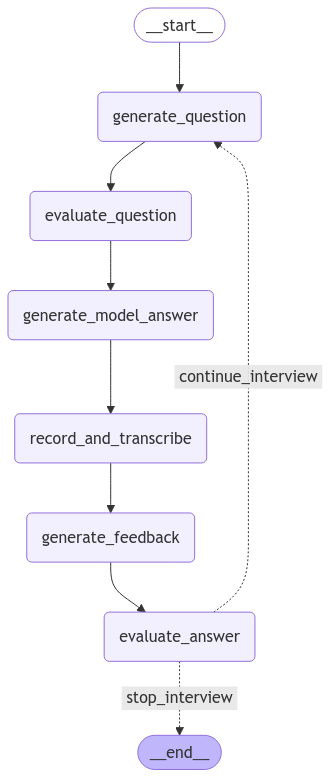

In [3]:
from IPython.display import Image, display

try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
# 메인 함수
def main():
    # 이력서 로드 및 키워드 추출 (필요에 따라 활성화)
    # resume_text = resume_loader(pdf_path)
    # extracted_keywords = extract_keywords_from_resume(resume_text)

    # 초기 상태 설정
    initial_state = {
        # "resume_text": resume_text,
        "tech_keywords": "python, binary file, argument, context, lambda, parameter",
        "is_stop": False,
        "question_count": 0,
        "max_questions": 5
    }

    # 그래프 실행
    run_mock_interview(compiled_graph, initial_state)


    # 스코어 그래프 생성
    score_images = plot_scores(interview_rounds)

    # PDF 보고서 생성
    create_pdf_report(interview_rounds, score_images)


main()


Recording started. Saving to recording_20241125_100014.avi
Current chunk state: {'generate_question': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': '"Unnamed: 0: sequence?\\nUnnamed: 1: Aniterablewhich supports efficient element access using integer indices via the__getitem__()special method and defines a__len__()method that returns the length of the sequence. Some built-in sequence types arelist,str,tuple, andbytes. Note thatdictalso supports__getitem__()and__len__(), but is considered a mapping rather than a sequence because the lookups use arbitraryhashablekeys rather than integers.Thecollections.abc.Sequenceabstract base class defines a much richer interface that goes beyond just__getitem__()and__len__(), addingcount(),index(),__contains__(), and__reversed__(). Types that implement this expanded interface can be registered explicitly usingregister(). For more documentation on sequence methods generally, seeCommon Sequence Operations.

Evaluating: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Current chunk state: {'evaluate_question': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': '"Unnamed: 0: sequence?\\nUnnamed: 1: Aniterablewhich supports efficient element access using integer indices via the__getitem__()special method and defines a__len__()method that returns the length of the sequence. Some built-in sequence types arelist,str,tuple, andbytes. Note thatdictalso supports__getitem__()and__len__(), but is considered a mapping rather than a sequence because the lookups use arbitraryhashablekeys rather than integers.Thecollections.abc.Sequenceabstract base class defines a much richer interface that goes beyond just__getitem__()and__len__(), addingcount(),index(),__contains__(), and__reversed__(). Types that implement this expanded interface can be registered explicitly usingregister(). For more documentation on sequence methods generally, seeCommon Sequence Operations.\\nsource: "', 'question': 'python에서 sequence라는 개념에 대해 설명해 

Evaluating: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


Results saved to 'mock_interview_results.csv'
Current chunk state: {'evaluate_answer': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': '"Unnamed: 0: sequence?\\nUnnamed: 1: Aniterablewhich supports efficient element access using integer indices via the__getitem__()special method and defines a__len__()method that returns the length of the sequence. Some built-in sequence types arelist,str,tuple, andbytes. Note thatdictalso supports__getitem__()and__len__(), but is considered a mapping rather than a sequence because the lookups use arbitraryhashablekeys rather than integers.Thecollections.abc.Sequenceabstract base class defines a much richer interface that goes beyond just__getitem__()and__len__(), addingcount(),index(),__contains__(), and__reversed__(). Types that implement this expanded interface can be registered explicitly usingregister(). For more documentation on sequence methods generally, seeCommon Sequence Operations.\\nsource: "', 

Evaluating: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Current chunk state: {'evaluate_question': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': 'amemoryviewof abytearray. Other operations require the binary data to be stored in immutable objects (???read-only bytes-like objects???); examples of these includebytesand amemoryviewof abytesobject.\\nsource: "', 'model_answer': 'Python에서 sequence는 효율적인 element 접근을 지원하는 iterable입니다. 이는 __getitem__() 특수 메소드를 통해 정수 인덱스를 활용하며, sequence의 길이를 반환하는 __len__() 메소드를 정의합니다. list, str, tuple, bytes는 built-in sequence 타입으로, 순서가 있는 요소의 집합을 다루는 데 매우 유용합니다. 현재 진행 중인 프로젝트에서 이러한 sequence 타입을 활용하여 데이터를 유연하게 관리하고 있습니다. 예를 들어, 리스트를 활용해 데이터를 쉽게 추가, 삭제하며, 튜플로 데이터의 불변성을 보장하고 있습니다. 또한, 문자열을 다룰 때는 str 타입을 활용해 각 문자에 쉽게 접근하거나 조작하고 있습니다. 이런 경험을 통해 Python의 sequence 타입이 데이터 처리에 있어 강력한 도구라는 것을 직접 체감하였습니다. 이러한 경험은 앞으로 다른 프로젝트에서도 활용될 것입니다.', 'question': '"이전 프로젝트에서 context라는 기술스택을 사용하셨다고 하셨는데, 그것이 무엇이고 어떠한 상황에서 사용하셨는지 설명해주실 수 있나요?"', 'answer_text': '비용을 맨날 놀러 가는데 이 애가 개방후 전화 ', '

Evaluating: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Results saved to 'mock_interview_results.csv'
Current chunk state: {'evaluate_answer': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': 'amemoryviewof abytearray. Other operations require the binary data to be stored in immutable objects (???read-only bytes-like objects???); examples of these includebytesand amemoryviewof abytesobject.\\nsource: "', 'model_answer': '"Context는 다양한 프로그래밍 언어에서 사용되는 개념으로, 특정 상황이나 환경을 가리키며, 데이터의 유효 범위나 데이터가 어떻게 처리되는지를 정의합니다. 제가 이전 프로젝트에서 Context를 사용한 상황은, 유저의 세션 데이터를 관리하는데 필요한 환경 설정을 처리하는데 있었습니다. 이때, Context를 통해 세션 데이터를 안전하게 관리하고, 이를 필요한 서비스 로직에 적절히 적용하는 역할을 담당했습니다. 이를 통해 개인화된 사용자 경험을 제공하면서도 데이터 보안을 유지할 수 있었습니다. 이 경험을 바탕으로, 앞으로도 다양한 환경에서 데이터를 효율적으로 관리하고 보안을 유지하는 데에 Context를 활용할 수 있을 것입니다."', 'question': '"이전 프로젝트에서 context라는 기술스택을 사용하셨다고 하셨는데, 그것이 무엇이고 어떠한 상황에서 사용하셨는지 설명해주실 수 있나요?"', 'answer_text': '교수님께 드실래요 되잖아  내일 마산 말 뭐라고 불러 ', 'evaluation': {'BERTScore': 0.5384243726730347, 'Answer_Relevancy': 0.0, 'Faithfu

Evaluating: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


Current chunk state: {'evaluate_question': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': '"Unnamed: 0: dictionary view?\\nUnnamed: 1: The objects returned fromdict.keys(),dict.values(), anddict.items()are called dictionary views. They provide a dynamic view on the dictionary???s entries, which means that when the dictionary changes, the view reflects these changes. To force the dictionary view to become a full list uselist(dictview).  SeeDictionary view objects.\\nsource: "', 'model_answer': '"Context는 다양한 프로그래밍 언어에서 사용되는 개념으로, 특정 상황이나 환경을 가리키며, 데이터의 유효 범위나 데이터가 어떻게 처리되는지를 정의합니다. 제가 이전 프로젝트에서 Context를 사용한 상황은, 유저의 세션 데이터를 관리하는데 필요한 환경 설정을 처리하는데 있었습니다. 이때, Context를 통해 세션 데이터를 안전하게 관리하고, 이를 필요한 서비스 로직에 적절히 적용하는 역할을 담당했습니다. 이를 통해 개인화된 사용자 경험을 제공하면서도 데이터 보안을 유지할 수 있었습니다. 이 경험을 바탕으로, 앞으로도 다양한 환경에서 데이터를 효율적으로 관리하고 보안을 유지하는 데에 Context를 활용할 수 있을 것입니다."', 'question': '이전 질문에서 binary file에 대해 말씀하셨는데, dictionary view와 함께 사용하여 binary file을 관리하거나 사용한

Evaluating: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Results saved to 'mock_interview_results.csv'
Current chunk state: {'evaluate_answer': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': '"Unnamed: 0: dictionary view?\\nUnnamed: 1: The objects returned fromdict.keys(),dict.values(), anddict.items()are called dictionary views. They provide a dynamic view on the dictionary???s entries, which means that when the dictionary changes, the view reflects these changes. To force the dictionary view to become a full list uselist(dictview).  SeeDictionary view objects.\\nsource: "', 'model_answer': '제가 데이터 분석 프로젝트를 수행하면서 binary file과 dictionary view를 함께 사용한 경험이 있습니다. 이번 프로젝트의 목표는 대용량 데이터를 효율적으로 분석하고 저장하는 것이었습니다. 하지만, 데이터의 크기가 너무 커서 메모리에 한 번에 올릴 수 없는 문제가 발생했습니다. 그래서 저는 dictionary view를 활용하여 데이터를 dynamic하게 불러오는 방법을 모색했습니다. 이를 통해, 필요한 부분만 불러와 사용함으로써 메모리 사용량을 크게 줄일 수 있었습니다. 또한, 분석 결과를 binary file로 저장하여 데이터 손실을 방지하였습니다. 이러한 과정을 통해 프로젝트는 성공적으로 완료되었고, 이 경험을 통해 대용량 데이터를 효율적으로 관리하는 방법을 배울 수 있었습니다. 앞으로 이러한 능력을 

Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


Current chunk state: {'evaluate_question': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': '"Unnamed: 0: bytes-like object?\\nUnnamed: 1: An object that supports theBuffer Protocoland can export a C-contiguousbuffer. This includes allbytes,bytearray, andarray.arrayobjects, as well as many commonmemoryviewobjects.  Bytes-like objects can be used for various operations that work with binary data; these include compression, saving to a binary file, and sending over a socket.Some operations need the binary data to be mutable.  The documentation often refers to these as ???read-write bytes-like objects???.  Example mutable buffer objects includebytearrayand amemoryviewof abytearray. Other', 'model_answer': '제가 데이터 분석 프로젝트를 수행하면서 binary file과 dictionary view를 함께 사용한 경험이 있습니다. 이번 프로젝트의 목표는 대용량 데이터를 효율적으로 분석하고 저장하는 것이었습니다. 하지만, 데이터의 크기가 너무 커서 메모리에 한 번에 올릴 수 없는 문제가 발생했습니다. 그래서 저는 dictionary view를 활용하여 데이터를 dynamic하게 불러오는 방법을 모색했습니다. 이를 통해, 필요한 부분만 

Evaluating: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Results saved to 'mock_interview_results.csv'
Current chunk state: {'evaluate_answer': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': '"Unnamed: 0: bytes-like object?\\nUnnamed: 1: An object that supports theBuffer Protocoland can export a C-contiguousbuffer. This includes allbytes,bytearray, andarray.arrayobjects, as well as many commonmemoryviewobjects.  Bytes-like objects can be used for various operations that work with binary data; these include compression, saving to a binary file, and sending over a socket.Some operations need the binary data to be mutable.  The documentation often refers to these as ???read-write bytes-like objects???.  Example mutable buffer objects includebytearrayand amemoryviewof abytearray. Other', 'model_answer': "'Bytes-like object'는 Buffer Protocol을 지원하고 C-contiguous buffer를 내보낼 수 있는 객체를 의미합니다. bytes, bytearray, array.array 객체 등이 이에 해당하며, 이는 바이너리 데이터를 다루는 다양한 작업에 사용될 수 있습니다. 예를 들어, 데이터 압축, 바이너리 파일 저장, 소켓을 

Evaluating: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Current chunk state: {'evaluate_question': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': '"Unnamed: 0: sequence?\\nUnnamed: 1: Aniterablewhich supports efficient element access using integer indices via the__getitem__()special method and defines a__len__()method that returns the length of the sequence. Some built-in sequence types arelist,str,tuple, andbytes. Note thatdictalso supports__getitem__()and__len__(), but is considered a mapping rather than a sequence because the lookups use arbitraryhashablekeys rather than integers.Thecollections.abc.Sequenceabstract base class defines a much richer interface that goes beyond just__getitem__()and__len__(), addingcount(),index(),__contains__(), and__reversed__(). Types that implement this expanded interface can be registered explicitly usingregister(). For more documentation on sequence methods generally, seeCommon Sequence Operations.\\nsource: "', 'model_answer': "'Bytes-like object'는 Buffer

Evaluating: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


Results saved to 'mock_interview_results.csv'
Current chunk state: {'evaluate_answer': {'tech_keywords': 'python, binary file, argument, context, lambda, parameter', 'ideal_answer': '"Unnamed: 0: sequence?\\nUnnamed: 1: Aniterablewhich supports efficient element access using integer indices via the__getitem__()special method and defines a__len__()method that returns the length of the sequence. Some built-in sequence types arelist,str,tuple, andbytes. Note thatdictalso supports__getitem__()and__len__(), but is considered a mapping rather than a sequence because the lookups use arbitraryhashablekeys rather than integers.Thecollections.abc.Sequenceabstract base class defines a much richer interface that goes beyond just__getitem__()and__len__(), addingcount(),index(),__contains__(), and__reversed__(). Types that implement this expanded interface can be registered explicitly usingregister(). For more documentation on sequence methods generally, seeCommon Sequence Operations.\\nsource: "', 

C:\Users\whdtl\AppData\Local\Temp\ipykernel_14052\2942796290.py:391: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\whdtl\AppData\Local\Temp\ipykernel_14052\2942796290.py:391: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\whdtl\AppData\Local\Temp\ipykernel_14052\2942796290.py:391: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\whdtl\AppData\Local\Temp\ipykernel_14052\2942796290.py:391: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\whdtl\AppData\Local\Temp\ipykernel_14052\2942796290.py:391: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\whdtl\AppData\Local\Temp\ipykernel_14052\2942796290.py:394: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) mis